# Normalise gene expression data and run two samples test

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html)  R package to normalise [fission](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data then run GPcounts two samples test.

### load [fission dataset](https://bioconductor.org/packages/3.11/data/experiment/html/fission.html) and normalise it using DESeq2

In [ ]:
library("fission")
data("fission")

In [ ]:
counts <- SummarizedExperiment::assay(fission)
col_data <- fission@colData

In [ ]:
library("DESeq2")

In [ ]:
library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data,
                              design = ~ strain + minute + strain:minute)


In [ ]:
dds <- estimateSizeFactors(dds)
counts_normalized <-counts(dds, normalized=TRUE)

In [ ]:
write.csv(counts_normalized, file = "fission_counts.csv")
write.csv(col_data, file = "fission_col_data.csv")

#### Change R kernel to Python kernel

In [1]:
import numpy as np
import pandas as pd

In [8]:
Y = pd.read_csv('fission_counts.csv',index_col=[0])
time_points = pd.read_csv('fission_col_data.csv',index_col=[0])
time_points = time_points[['minute']]

In [13]:
X = time_points
#X = (X  - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
#X = pd.DataFrame(data= X,index = time_points.index,columns=['pseudotime'])
#X.shape

Fit the first gene in fission gene expression data using GPcounts -- Two samples test

In [14]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = ['SPBC1271.07c','SPAC186.04c','SPAC186.06','SPBC2A9.11c']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name]) 
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

100%|██████████| 4/4 [00:24<00:00,  6.18s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPBC1271.07c,-171.245132,-80.721851,-84.121842,6.401439
SPAC186.04c,-116.898056,-43.982928,-60.278834,12.636294
SPAC186.06,-93.108174,-23.701119,-55.245252,14.161804
SPBC2A9.11c,-198.548799,-97.383473,-103.258874,-2.093548


SPBC1271.07c


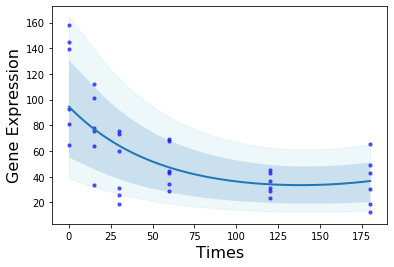

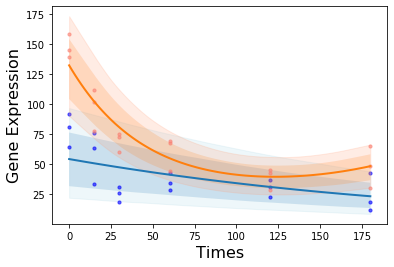

SPAC186.04c


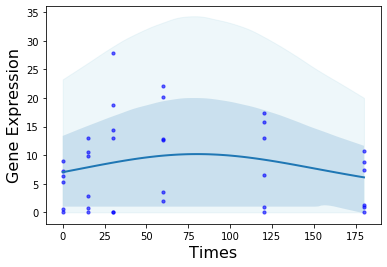

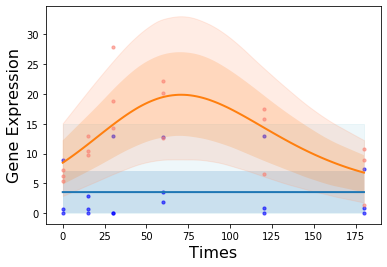

SPAC186.06


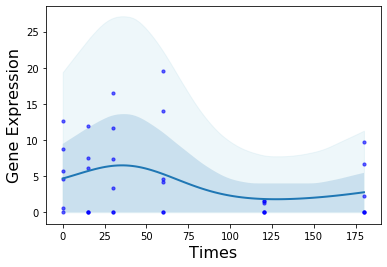

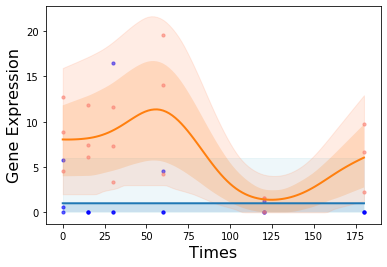

SPBC2A9.11c


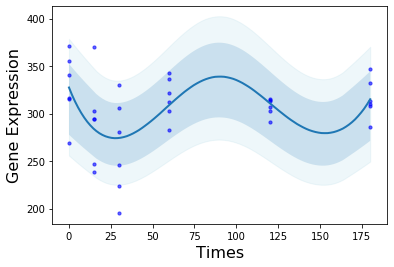

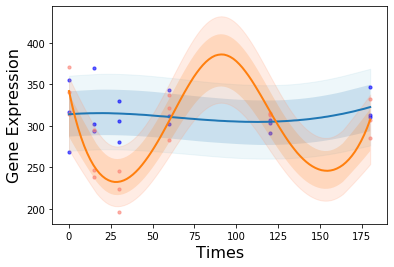

In [15]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot(likelihood,xtest,model,mean,var,count):
         
    plt.ylabel('Gene Expression', fontsize=16)
    plt.xlabel('Times', fontsize=16)
    
    if count == 1 or count == 2:
        c = 'blue'

    else:
        c = 'salmon'
    
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]), alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color='light'+c, alpha=0.2)# two standard deviation
    else:
        
        lowess = sm.nonparametric.lowess
        
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,alpha = 0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color='light'+c,alpha = 0.2)
        
    plt.plot(xtest, mean, lw=2) 
    plt.scatter(model.data[0],model.data[1], s=10, color= c, alpha=0.6) #data

    if count == 1 or count ==3:
        plt.show()
        
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values),np.max(X.values),100)[:,None] # points to make prediction
sample = True # sample or/and load model 
likelihood = 'Negative_binomial'
params = gp_counts.load_and_sample_models(indexes,test,xtest,likelihood,sample)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    count = 1
    for models,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        mean = np.array(mean)
        var = np.array(var)
        plot(likelihood,xtest,models,mean,var,count)
        count = count + 1

In [16]:
likelihood = 'Gaussian'
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPBC1271.07c,-30.895298,-15.335144,-8.176317,7.383837
SPAC186.04c,-56.957426,-27.508666,-16.878753,12.570007
SPAC186.06,-55.934383,-23.346945,-21.715445,10.871993
SPBC2A9.11c,7.379950,47.399634,-0.872361,39.147323


SPBC1271.07c


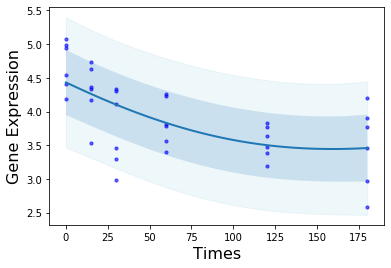

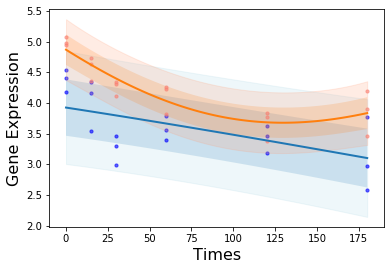

SPAC186.04c


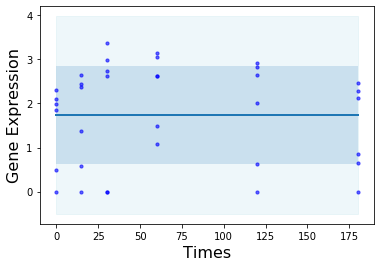

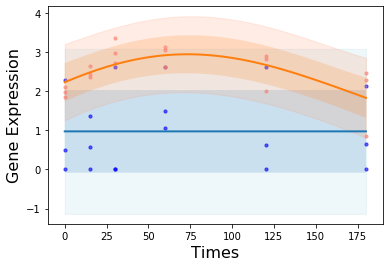

SPAC186.06


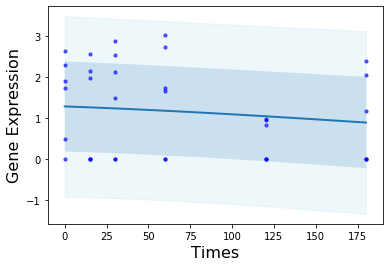

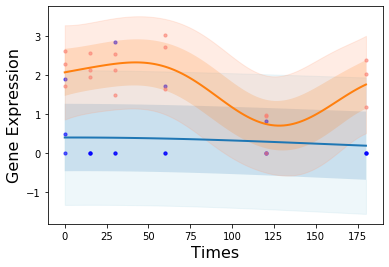

SPBC2A9.11c


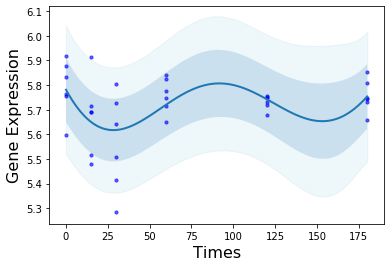

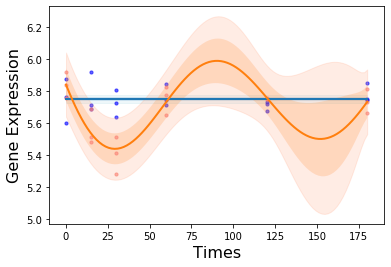

In [17]:
params = gp_counts.load_and_sample_models(indexes,test,xtest,likelihood,sample)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    count = 1
    for models,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        mean = np.array(mean)
        var = np.array(var)
        plot(likelihood,xtest,models,mean,var,count)
        count = count + 1